In [1]:
from backend.models.model_nnext import ModelNNext
from configs.config import get_cfg
import matplotlib.pyplot as plt
import numpy as np

cfg = get_cfg("model_finance.yaml")

# Instantiate and print the model
model = ModelNNext(cfg)
model.prepare_data()
model.build()

[*********************100%***********************]  5 of 5 completed


In [2]:
model.train()

Epoch: 0
Train - Loss: 201.9630
Valid - Loss: 61.9214
Epoch: 1
Train - Loss: 100.5191
Valid - Loss: 61.7827
Epoch: 2
Train - Loss: 97.5989
Valid - Loss: 63.9442
Epoch: 3
Train - Loss: 92.5968
Valid - Loss: 69.5828
Epoch: 4
Train - Loss: 89.1159
Valid - Loss: 64.5419
Epoch: 5
Train - Loss: 80.5758
Valid - Loss: 68.3281
Epoch: 6
Train - Loss: 73.9362
Valid - Loss: 64.6165
Epoch: 7
Train - Loss: 73.5924
Valid - Loss: 65.0981
Epoch: 8
Train - Loss: 68.8130
Valid - Loss: 66.1902
Epoch: 9
Train - Loss: 61.9892
Valid - Loss: 70.0855
Stopping early due to 3 many consecutive increases in validation loss. Loading back earlier model.


[[ 0.23370358  0.8175204   0.5889002   0.4666381   0.85790503]
 [ 0.4566995   0.85331863  0.58311856  0.52310574  0.29990137]
 [ 0.59666455  0.9936544   0.6499583   0.6944542   0.6506525 ]
 ...
 [ 1.1441443   1.8853213   1.1816292   1.3344637   0.9360548 ]
 [-0.03628448  0.32910043  0.1628374   0.02890104  0.59707284]
 [ 0.14579543  0.85999125  0.4459169   0.02015313  0.47068322]]
(250, 5)


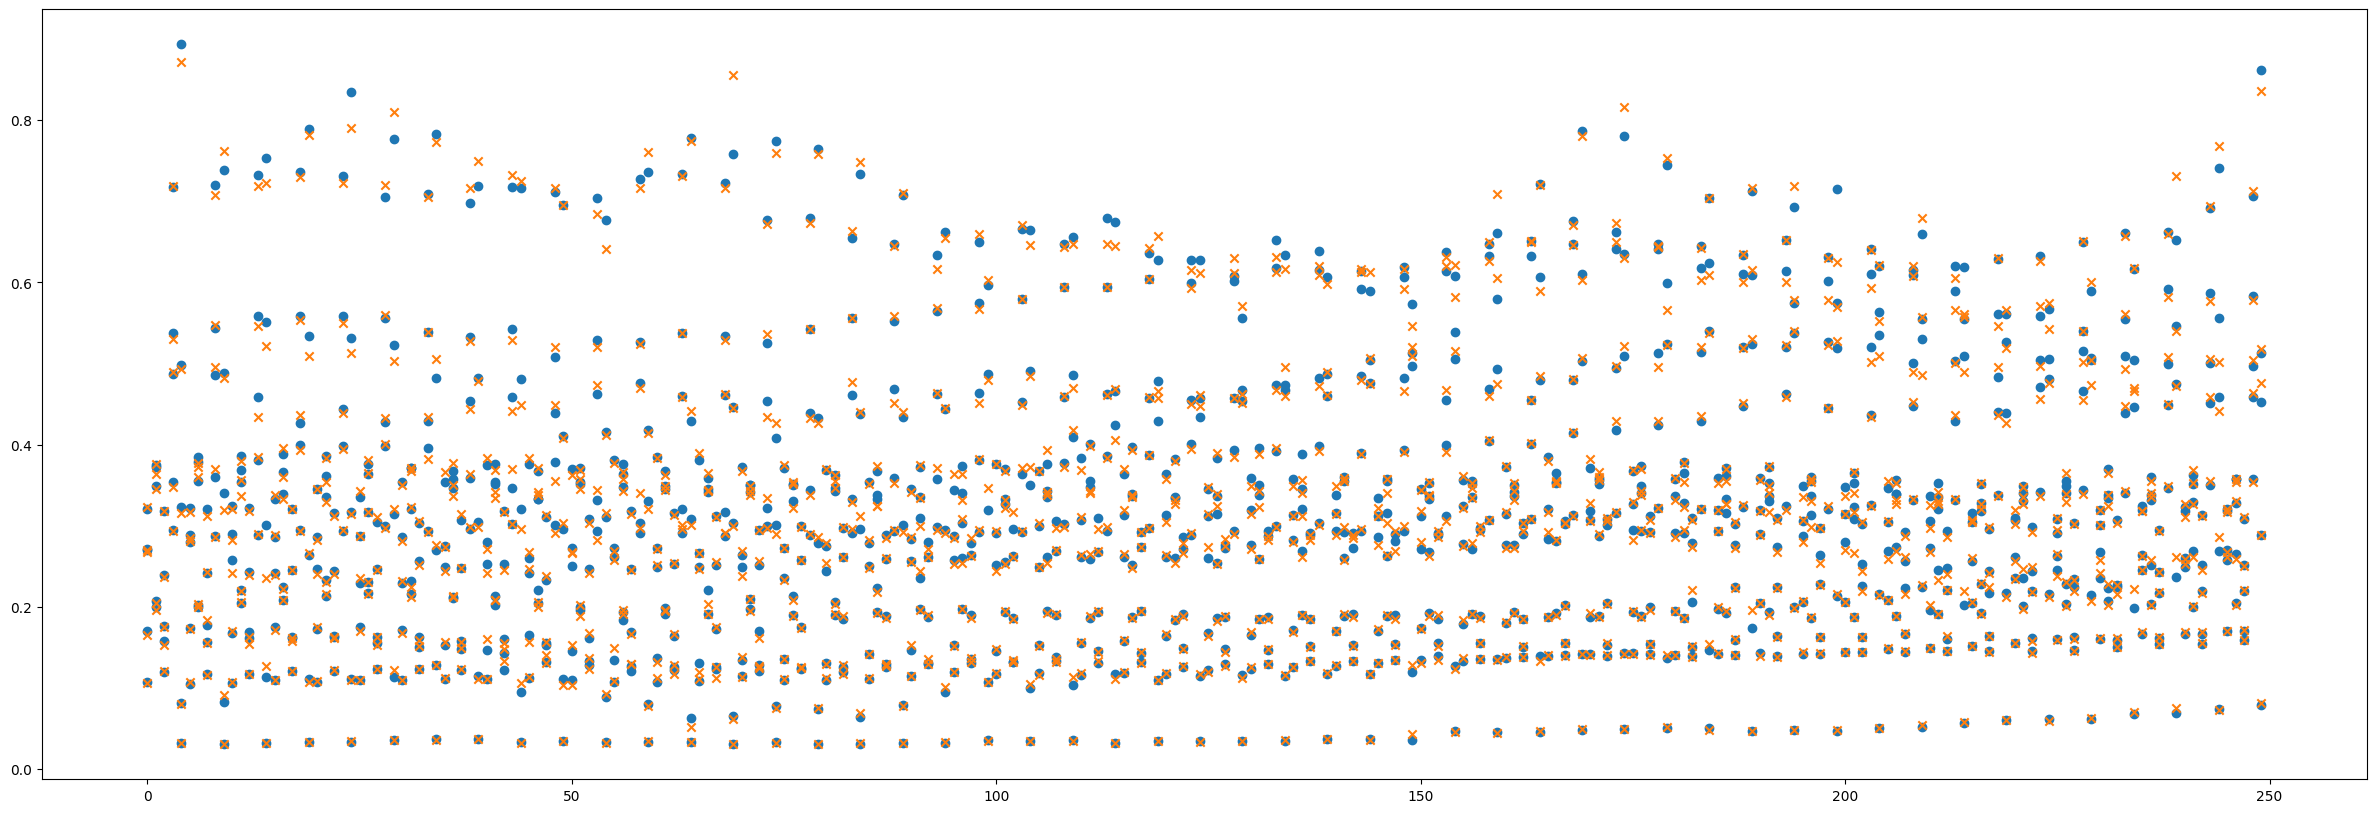

In [3]:
Ypred = model.evaluate(model.data.X_test_set.reshaped_2D_tensor()).numpy()
Ytrue = model.data.Y_test_set.ndarray
floorYtest = model.data.Ybis_test_set.ndarray

print(Ypred)
Ypred= (Ypred/100+1)*floorYtest
Ytrue= (Ytrue/100+1)*floorYtest

plt.figure(figsize=(30,10))
print(Ytrue.shape)
t = np.array([range(len(Ypred)) for i in range(len(Ypred[0]))])
plt.scatter(t,Ypred)
plt.scatter(t,Ytrue, marker='x')

# # plt.plot(range(n2,n1),full_pred_series,alpha = 0.7, linestyle='--')
plt.show()

Text(0, 0.5, 'Cumulative returns (%)')

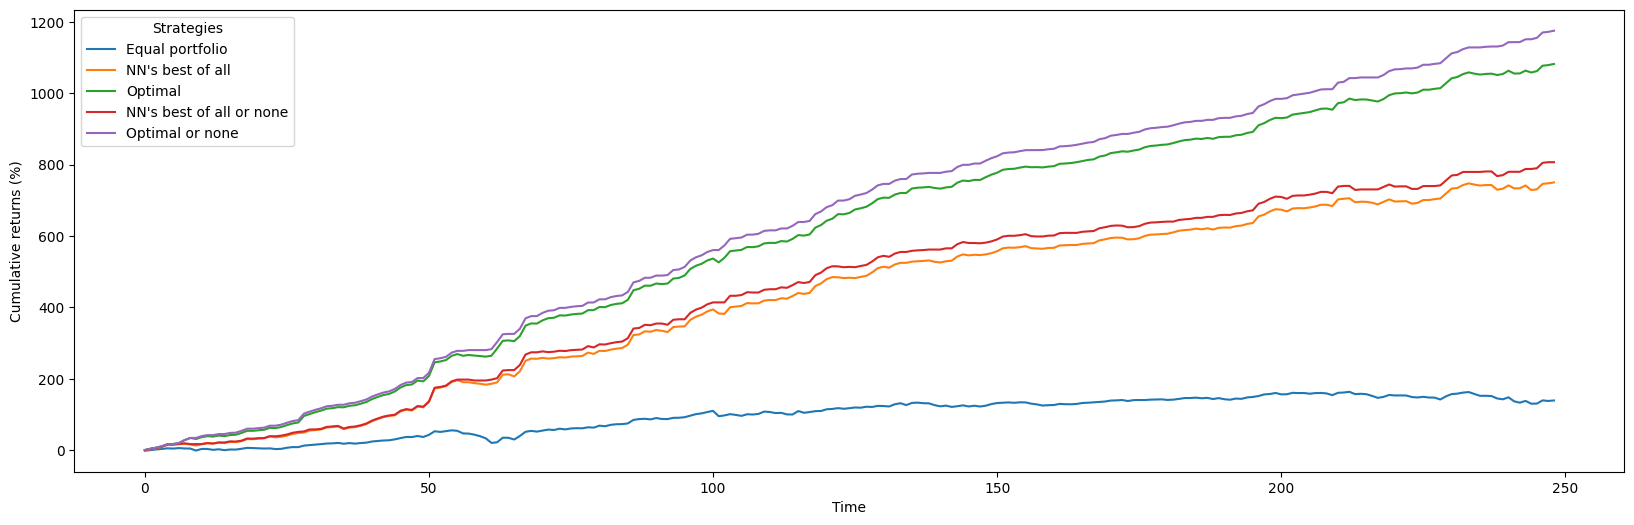

In [4]:
#### Return of the asset vs return on-off if up or down prediction.
import numpy as np
# Calculate percentage change
def pctc(arr):
  return np.diff(arr,axis = 0) / arr[:-1,:] * 100

PCa = pctc(Ytrue)
# PCb = np.copy(PCa)
# PCmax = np.copy(PCa)

temp = pctc(Ypred)
# PCb[temp<=0] = 0 # our prediction might tell us when to sell/buy (each time there is a increase/decrease pred)
# PCmax[PCa<=0] =0 # can't get more returns than when knowing the real time-series values and selling when decrease incoming.
PCmax = np.maximum.reduce(PCa,axis=1)
PCmaxBis = np.maximum(PCmax,0.0)


max_indices = np.argmax(temp, axis=1)

# PCb = PCa[:,max_indices]
PCb = PCa[np.arange(PCa.shape[0]), max_indices]

temp  = np.hstack((temp,np.zeros((temp.shape[0], 1))))
max_indices_with_zero = np.argmax(temp, axis=1)
PCa_and_cash = np.hstack((PCa,np.zeros((PCa.shape[0], 1))))

PCbBis = PCa_and_cash[np.arange(PCa_and_cash.shape[0]), max_indices_with_zero]

PCequal = np.sum(PCa,axis = 1)/len(PCa[0]) #if just having the same amount of each asset.

# cumulate the pct changes
PCequal = PCequal.cumsum()
PCb = PCb.cumsum()
PCmax = PCmax.cumsum()
PCbBis = PCbBis.cumsum()
PCmaxBis = PCmaxBis.cumsum()

# Plot
fig = plt.figure(figsize=(20,6))
plt.plot(PCequal)
plt.plot(PCb)
plt.plot(PCmax)
plt.plot(PCbBis)
plt.plot(PCmaxBis)
plt.legend(['Equal portfolio',"NN's best of all",'Optimal', "NN's best of all or none", 'Optimal or none'], title = 'Strategies')
plt.xlabel('Time')
plt.ylabel('Cumulative returns (%)')